In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional for better plots
sns.set(style='whitegrid')
#df_original = pd.read_csv("scraped_essays.csv")
df_augmented = pd.read_csv("essays_with_augmentation.csv")
print(df_augmented.head())

   author                 school  year_written  \
0  Skyler  Hwa Chong Institution          2021   
1  Skyler  Hwa Chong Institution          2021   
2  Skyler  Hwa Chong Institution          2021   
3  Junwei  Hwa Chong Institution          2020   
4  Junwei  Hwa Chong Institution          2020   

                                               title      type  \
0  ‘Prosperity is all that matters; everything el...  original   
1  Do you agree that freedom of speech should nev...  original   
2  ‘When children grow up exposed to violence, th...  original   
3  A government that fails to win the trust of th...  original   
4  To what extent is the use of violence in today...  original   

                                                text  score  
0  Hong Kong no doubt boasts some of the wealthie...      A  
1  Freedom of speech is, to the Western world, a ...      A  
2  Since time immemorial, humanity has been plagu...      A  
3  The 2020 U.S. Presidential Election seemed to ...  

In [45]:
import pandas as pd
import numpy as np

# Function to normalize score values
def normalize_score(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip()
    if val == "A":
        return 43
    if "/" in val:
        try:
            return int(val.split("/")[0])
        except:
            return np.nan
    try:
        return float(val)
    except:
        return np.nan

# Apply normalization
df_augmented['score'] = df_augmented['score'].apply(normalize_score)


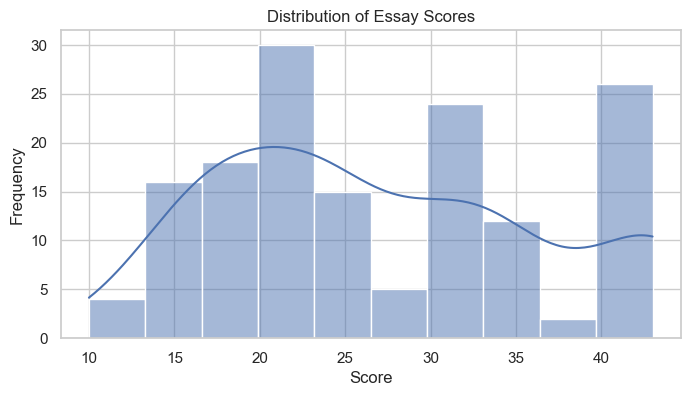

In [46]:
plt.figure(figsize=(8, 4))
sns.histplot(df_augmented['score'].dropna(), bins=10, kde=True)
plt.title("Distribution of Essay Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

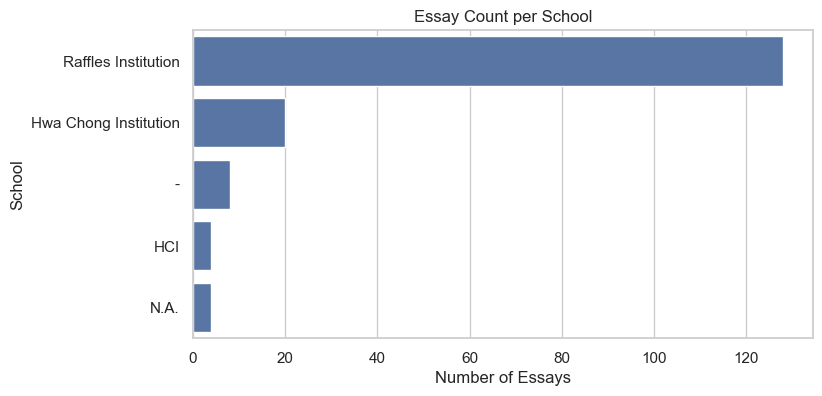

In [47]:
plt.figure(figsize=(8, 4))
sns.countplot(y='school', data=df_augmented, order=df_augmented['school'].value_counts().index)
plt.title("Essay Count per School")
plt.xlabel("Number of Essays")
plt.ylabel("School")
plt.show()

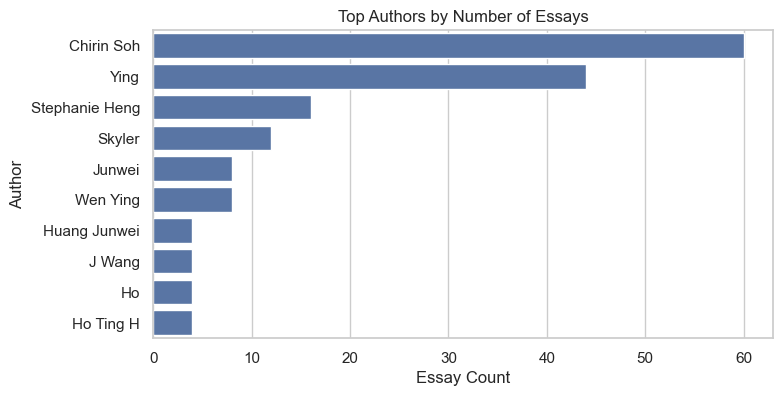

In [48]:
plt.figure(figsize=(8, 4))
sns.countplot(y='author', data=df_augmented, order=df_augmented['author'].value_counts().head(10).index)
plt.title("Top Authors by Number of Essays")
plt.xlabel("Essay Count")
plt.ylabel("Author")
plt.show()

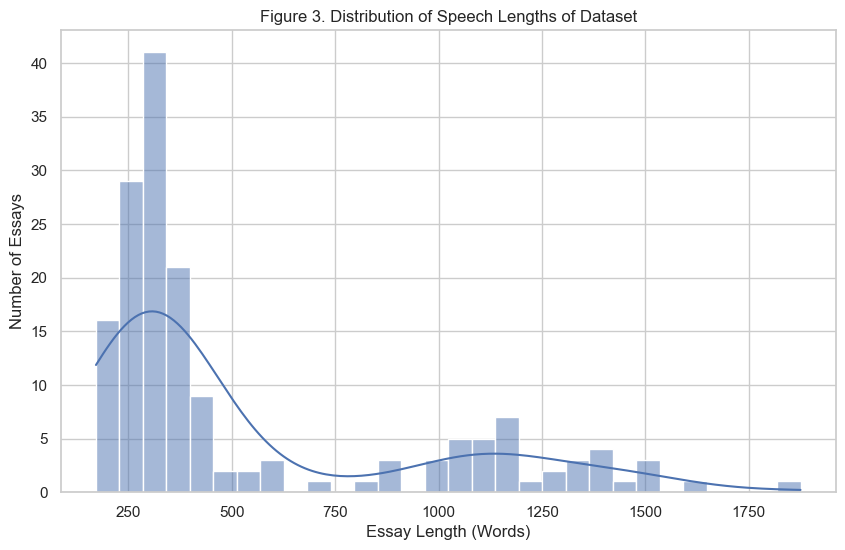

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate essay word count
df_augmented['word_count'] = df_augmented['text'].apply(lambda x: len(str(x).split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_augmented['word_count'], bins=30, kde=True)
plt.title("Figure 3. Distribution of Speech Lengths of Dataset")
plt.xlabel("Essay Length (Words)")
plt.ylabel("Number of Essays")
plt.grid(True)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vyshalibhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


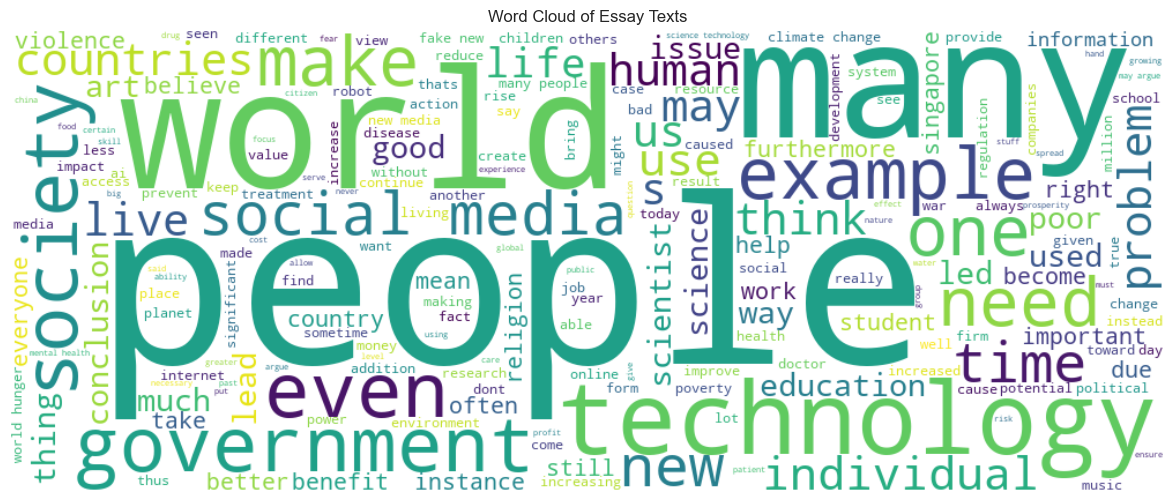

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
# Combine all essay text into a single string
all_essays = " ".join(df_augmented['text'].dropna().astype(str))

# Basic preprocessing
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation and stopwords
cleaned_essays = " ".join(
    word for word in all_essays.translate(translator).lower().split()
    if word not in stop_words
)
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(cleaned_essays)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Essay Texts')
plt.show()

In [13]:
pip install language-tool-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [51]:
import language_tool_python

# Use the public remote server (no Java required)
tool = language_tool_python.LanguageTool('en-GB', remote_server='https://api.languagetool.org')

def grammar_errors(text):
    matches = tool.check(text)
    return len(matches)


def split_text(text, max_words=300):
    words = text.split()
    return [' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

def grammar_errors_chunked(text):
    chunks = split_text(text)
    total_errors = 0
    for chunk in chunks:
        try:
            matches = tool.check(chunk)
            total_errors += len(matches)
        except Exception as e:
            print(f"Error checking chunk: {e}")
    return total_errors

df_augmented['grammar_errors_uk'] = df_augmented['text'].apply(grammar_errors_chunked)



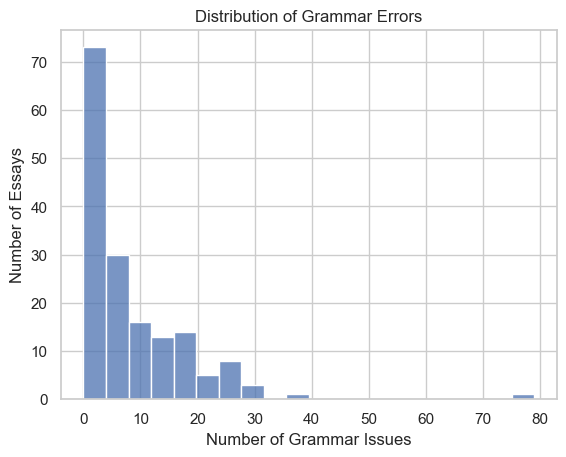

In [53]:
sns.histplot(df_augmented['grammar_errors_uk'], bins=20)
plt.title("Distribution of Grammar Errors")
plt.xlabel("Number of Grammar Issues")
plt.ylabel("Number of Essays")
plt.show()

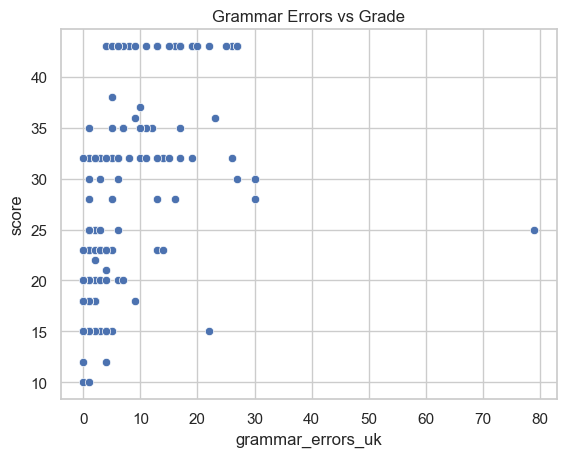

In [54]:
sns.scatterplot(x='grammar_errors_uk', y='score', data=df_augmented)
plt.title("Grammar Errors vs Grade")
plt.show()


In [19]:
pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [62]:
# Normalize the type column (lowercase for safe comparison)
df_augmented['type_clean'] = df_augmented['type'].str.lower()

# Get original essays
df_original_essays = df_augmented[df_augmented['type_clean'] == 'original']['text'].tolist()

# Get all augmented essays (i.e., non-originals)
df_augmented_essays = df_augmented[df_augmented['type_clean'] != 'original']['text'].tolist()[:41]

# Optional: print the count
print("Original essays:", len(df_original_essays))
print("Augmented essays:", len(df_augmented_essays))

Original essays: 41
Augmented essays: 41


In [63]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode
original_embeddings = model.encode(df_original_essays, convert_to_tensor=True)
augmented_embeddings = model.encode(df_augmented_essays, convert_to_tensor=True)

# Compute similarity
similarities = [util.pytorch_cos_sim(o, a).item() for o, a in zip(original_embeddings, augmented_embeddings)]

# Output
df_similarity = pd.DataFrame({
    "original": df_original_essays,
    "augmented": df_augmented_essays,
    "semantic_similarity": similarities
})
print(df_similarity)

                                             original  \
0   Hong Kong no doubt boasts some of the wealthie...   
1   Freedom of speech is, to the Western world, a ...   
2   Since time immemorial, humanity has been plagu...   
3   The 2020 U.S. Presidential Election seemed to ...   
4   In the aftermath of the Second World War, the ...   
5   In 1949, soon after the the Communists’ victor...   
6   We may have never been a Galileo of the artist...   
7   Education is often naively thought to be the h...   
8   The culture of disposables has gone too far. I...   
9   Since the Industrial revolution, the use of te...   
10  In the 21st century, increasingly declining bi...   
11  In our fast paced society, modern technology i...   
12  In the 2018 world economic forum, environmenta...   
13  People are inherently curious, and will always...   
14  As the world is rapidly evolving, Science and ...   
15  Since the scientific revolution, Science has m...   
16  As Albert Einstein once apt

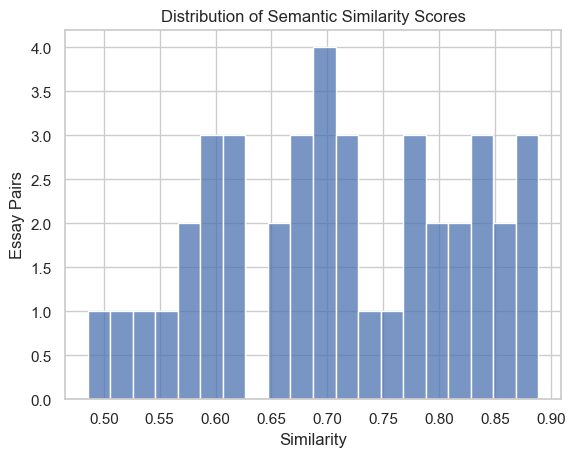

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(similarities, bins=20)
plt.title("Distribution of Semantic Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Essay Pairs")
plt.show()

In [23]:
pip install textstat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


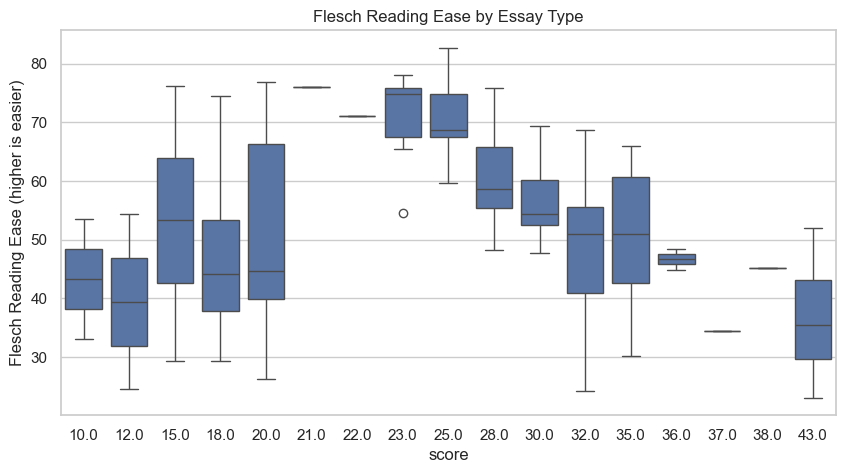

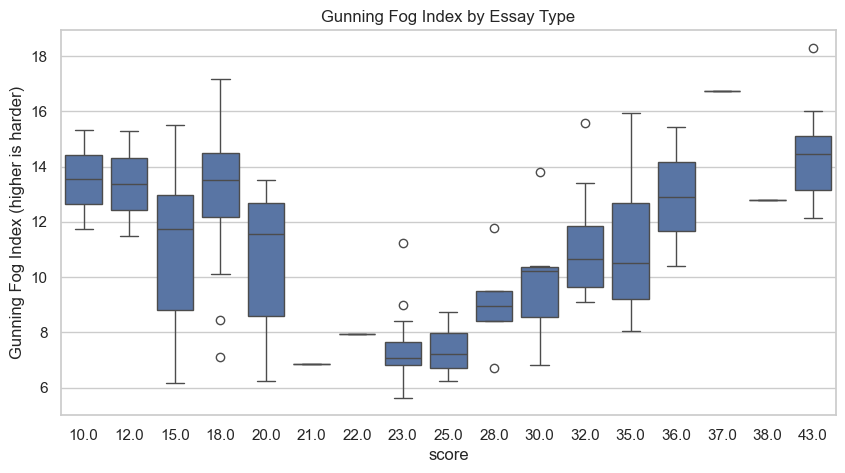

In [65]:
import pandas as pd
import textstat
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called `df` and has 'text' and 'type' columns

# Compute readability metrics
df_augmented['flesch_reading_ease'] = df_augmented['text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
df_augmented['gunning_fog'] = df_augmented['text'].apply(lambda x: textstat.gunning_fog(str(x)))

# 📊 Plot: Flesch Reading Ease
plt.figure(figsize=(10, 5))
sns.boxplot(x='score', y='flesch_reading_ease', data=df_augmented)
plt.title("Flesch Reading Ease by Essay Type")
plt.ylabel("Flesch Reading Ease (higher is easier)")
plt.show()

# 📊 Plot: Gunning Fog Index
plt.figure(figsize=(10, 5))
sns.boxplot(x='score', y='gunning_fog', data=df_augmented)
plt.title("Gunning Fog Index by Essay Type")
plt.ylabel("Gunning Fog Index (higher is harder)")
plt.show()